# Add PCA, clustering, annotations for nuclei and cells to sdata / bone_marrow_s1

In [1]:
slide_id = 'bone_marrow_s1'

In [2]:
import os
import pandas as pd
import spatialdata as sd
import numpy as np
import anndata as ad
import scanpy as sc
from spatialdata.models import get_table_keys

In [3]:
def combine_adatas(slide_id):

    # Load the data
    
    sdata = sd.read_zarr(f"/Volumes/DD_FGS/MICS/data_HE2CellType/CT_DS/sdata_final/sdata_{slide_id}.zarr", selection=('tables', 'shapes'))
    adata_ini_nuclei = sdata.tables['table_nuclei'].copy()
    adata_ini_cells = sdata.tables['table_cells'].copy()
    
    adata_nuclei = sc.read_h5ad(f"/Volumes/DD_FGS/MICS/data_HE2CellType/CT_DS/adata_refine_tangram/adata_refine_tangram_{slide_id}.h5ad")
    adata_cells = sc.read_h5ad(f"/Volumes/DD_FGS/MICS/data_HE2CellType/CT_DS/adata_annots_cells/adata_annots_cells_{slide_id}.h5ad")
    adata_scvi = sc.read_h5ad(f"/Volumes/DD_FGS/MICS/data_HE2CellType/CT_DS/adata_scvi/adata_scvi_{slide_id}.h5ad")

    adata_missing_nuclei = adata_ini_nuclei[~adata_ini_nuclei.obs_names.isin(adata_nuclei.obs_names)].copy()
    adata_missing_cells = adata_ini_cells[~adata_ini_cells.obs_names.isin(adata_cells.obs_names)].copy()

    # Combine the data
    adata_combined_nuclei = ad.concat([adata_nuclei, adata_missing_nuclei], join="outer", merge="first", uns_merge="first", pairwise=True)
    adata_combined_cells = ad.concat([adata_cells, adata_missing_cells], join="outer", merge="first", uns_merge="first", pairwise=True)
    adata_combined_scvi = ad.concat([adata_scvi, adata_missing_cells], join="outer", merge="first", uns_merge="first", pairwise=True)

    # Checking

    print("\n")
    print(f"### Doing {slide_id} ###")

    print("\n\nNuclei:\n")

    print(f"Checking shapes: {adata_nuclei.shape[0] + adata_missing_nuclei.shape[0] == adata_ini_nuclei.shape[0]} and {adata_combined_nuclei.shape == adata_ini_nuclei.shape}")
    print("\n")
    print(adata_combined_nuclei)
    
    print("\n\nCells:\n")

    print(f"Checking shapes: {adata_cells.shape[0] + adata_missing_cells.shape[0] == adata_ini_cells.shape[0]} and {adata_combined_cells.shape == adata_ini_cells.shape}")
    print("\n")
    print(adata_combined_cells)

    print("\n\nSCVI:\n")

    print(f"Checking shapes: {adata_scvi.shape[0] + adata_missing_cells.shape[0] == adata_ini_cells.shape[0]} and {adata_combined_scvi.shape == adata_ini_cells.shape}")
    print("\n")
    print(adata_combined_scvi)

    return sdata, adata_combined_nuclei, adata_combined_cells, adata_combined_scvi

In [4]:
sdata, adata_combined_nuclei, adata_combined_cells, adata_combined_scvi = combine_adatas(slide_id)

/Users/felicie-giraud-sauveur/miniforge3/envs/cluster/lib/python3.10/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)




### Doing bone_marrow_s1 ###


Nuclei:

Checking shapes: True and True


AnnData object with n_obs × n_vars = 84518 × 541
    obs: 'region', 'slide', 'cell_id', 'area', 'ct_tangram', 'transcript_counts', 'pca_n10_pcs11_leiden_res0.2', 'pca_n10_pcs11_leiden_res0.4', 'pca_n10_pcs11_leiden_res0.6', 'refine_res', 'label1', 'label2', 'label3'
    var: 'mean', 'std'
    uns: 'ct_tangram_colors', 'label1_colors', 'label2_colors', 'label3_colors', 'pca', 'pca_n10_pcs11', 'pca_n10_pcs11_leiden_res0.2', 'pca_n10_pcs11_leiden_res0.2_colors', 'pca_n10_pcs11_leiden_res0.4', 'pca_n10_pcs11_leiden_res0.4_colors', 'pca_n10_pcs11_leiden_res0.6', 'pca_n10_pcs11_leiden_res0.6_colors', 'rank_genes_pca_n10_pcs11_leiden_res0.2', 'rank_genes_pca_n10_pcs11_leiden_res0.4', 'rank_genes_refine_res', 'refine_res_colors', 'sopa_attrs', 'spatialdata_attrs', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'tangram_pred'
    varm: 'PCs'
    layers: 'count', 'log_norm'
    obsp: 'pca_n10_pcs11_connectivities', 'pca_n

/Users/felicie-giraud-sauveur/miniforge3/envs/cluster/lib/python3.10/site-packages/anndata/_core/merge.py:1358: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


In [5]:
# Add transcript counts values to nuclei with less than 10 transcripts
nuclei_with_na = adata_combined_nuclei.obs['transcript_counts'].isna()
transcript_sums = adata_combined_nuclei[nuclei_with_na].X.sum(axis=1)
adata_combined_nuclei.obs.loc[nuclei_with_na, 'transcript_counts'] = np.ravel(transcript_sums)

In [6]:
del sdata.tables['table_nuclei']
del sdata.tables['table_cells']
sdata.tables['table_nuclei'] = adata_combined_nuclei
sdata.tables['table_cells'] = adata_combined_cells
sdata.tables['table_scvi'] = adata_combined_scvi

In [7]:
# Add label for nuclei/cells with less than 10 transcripts

for table in ['table_nuclei', 'table_cells']:
    for label in ['label1', 'label2', 'label3']:
        sdata.tables[table].obs[label] = sdata.tables[table].obs[label].cat.add_categories(['less10'])
        sdata.tables[table].obs.loc[sdata.tables[table].obs['transcript_counts']<=10, label] = 'less10'

In [8]:
# Add label for scvi with less than 10 transcripts
sdata.tables['table_scvi'].obs['label1'] = sdata.tables['table_scvi'].obs['label1'].cat.add_categories(['less10'])
sdata.tables['table_scvi'].obs.loc[sdata.tables['table_scvi'].obs['transcript_counts']<=10, 'label1'] = 'less10'

In [9]:
# Discretize transcript_counts to check that clustering is not driven by this

sdata.tables['table_nuclei'].obs['transcript_cat'] = pd.qcut(sdata.tables['table_nuclei'].obs['transcript_counts'], q=7, labels=False)
sdata.tables['table_nuclei'].obs['transcript_cat'] = pd.Categorical(sdata.tables['table_nuclei'].obs['transcript_cat'])

sdata.tables['table_cells'].obs['transcript_cat'] = pd.qcut(sdata.tables['table_cells'].obs['transcript_counts'], q=7, labels=False)
sdata.tables['table_cells'].obs['transcript_cat'] = pd.Categorical(sdata.tables['table_cells'].obs['transcript_cat'])

In [10]:
# Idem with log transcript counts
sdata.tables['table_nuclei'].obs['transcript_counts_log'] = np.log1p(sdata.tables['table_nuclei'].obs['transcript_counts'])
sdata.tables['table_cells'].obs['transcript_counts_log'] = np.log1p(sdata.tables['table_cells'].obs['transcript_counts'])

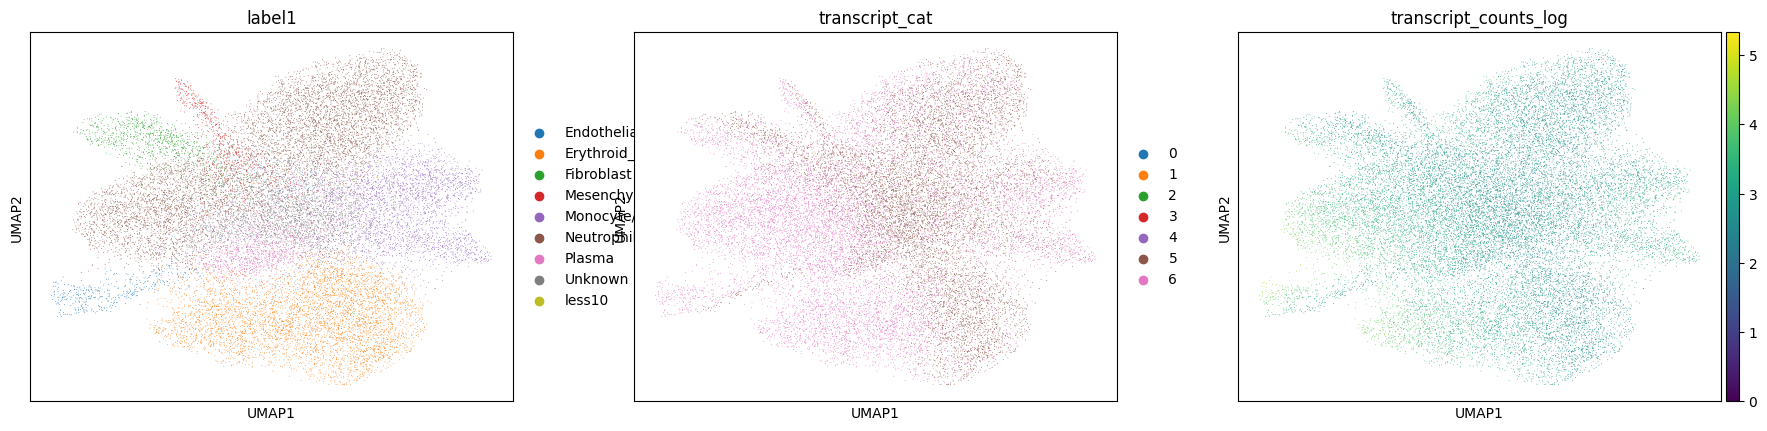

In [11]:
# Checking that clustering is not driven by number of transcripts for nuclei
sc.pl.umap(sdata.tables['table_nuclei'], neighbors_key='pca_n10_pcs16',
           color=['label1', 'transcript_cat', 'transcript_counts_log'])

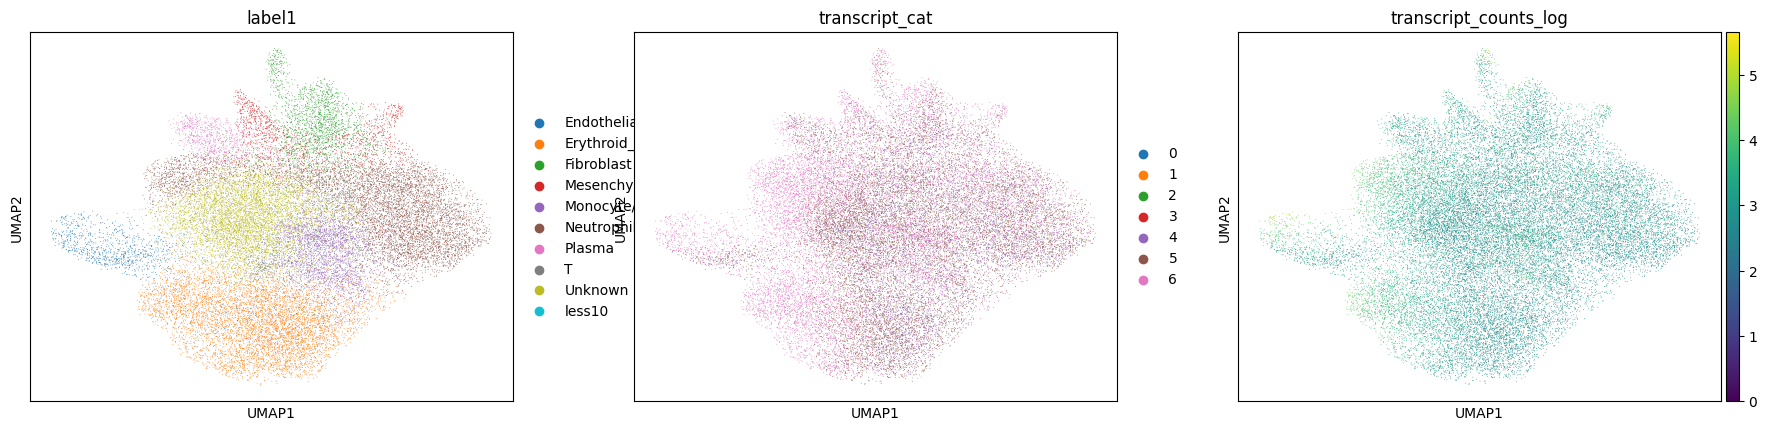

In [12]:
# Checking that clustering is not driven by number of transcripts for cells
sc.pl.umap(sdata.tables['table_cells'], neighbors_key='pca_n10_pcs16',
           color=['label1', 'transcript_cat', 'transcript_counts_log'])

In [13]:
# Put table_nuclei as annotating nucleus_boundaries

sdata["table_nuclei"].obs["region"] = "nucleus_boundaries"
sdata.tables["table_nuclei"].obs['region'] = sdata.tables["table_nuclei"].obs['region'].astype('category')
sdata.set_table_annotates_spatialelement(table_name="table_nuclei", region="nucleus_boundaries", region_key="region", instance_key="cell_id")

region, region_key, instance_key = get_table_keys(sdata["table_nuclei"])
print(region, region_key, instance_key)

nucleus_boundaries region cell_id


In [14]:
# Put table_cells as annotating cell_boundaries

sdata["table_cells"].obs["region"] = "cell_boundaries"
sdata.tables["table_cells"].obs['region'] = sdata.tables["table_cells"].obs['region'].astype('category')
sdata.set_table_annotates_spatialelement(table_name="table_cells", region="cell_boundaries", region_key="region", instance_key="cell_id")

region, region_key, instance_key = get_table_keys(sdata["table_cells"])
print(region, region_key, instance_key)

cell_boundaries region cell_id


In [15]:
# Put table_scvi as annotating cell_boundaries

sdata["table_scvi"].obs["region"] = "cell_boundaries"
sdata.tables["table_scvi"].obs['region'] = sdata.tables["table_scvi"].obs['region'].astype('category')
sdata.set_table_annotates_spatialelement(table_name="table_scvi", region="cell_boundaries", region_key="region", instance_key="cell_id")

region, region_key, instance_key = get_table_keys(sdata["table_scvi"])
print(region, region_key, instance_key)

cell_boundaries region cell_id


In [16]:
# Save on disk

sdata.delete_element_from_disk('table_nuclei')
sdata.write_element('table_nuclei')

sdata.delete_element_from_disk('table_cells')
sdata.write_element('table_cells')

sdata.write_element('table_scvi')